In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda') # torch.device('cpu')
device

device(type='cuda')

In [3]:
rng = np.random.default_rng(73512)

# Dane syntetyczne

In [4]:
indices = np.arange(0, 50, 0.02)
synthetic_data = (np.sin(indices * 3) + indices / 10 + (indices / 10) ** 2 + np.sin(indices * 10)) #/ np.exp(indices / 20)

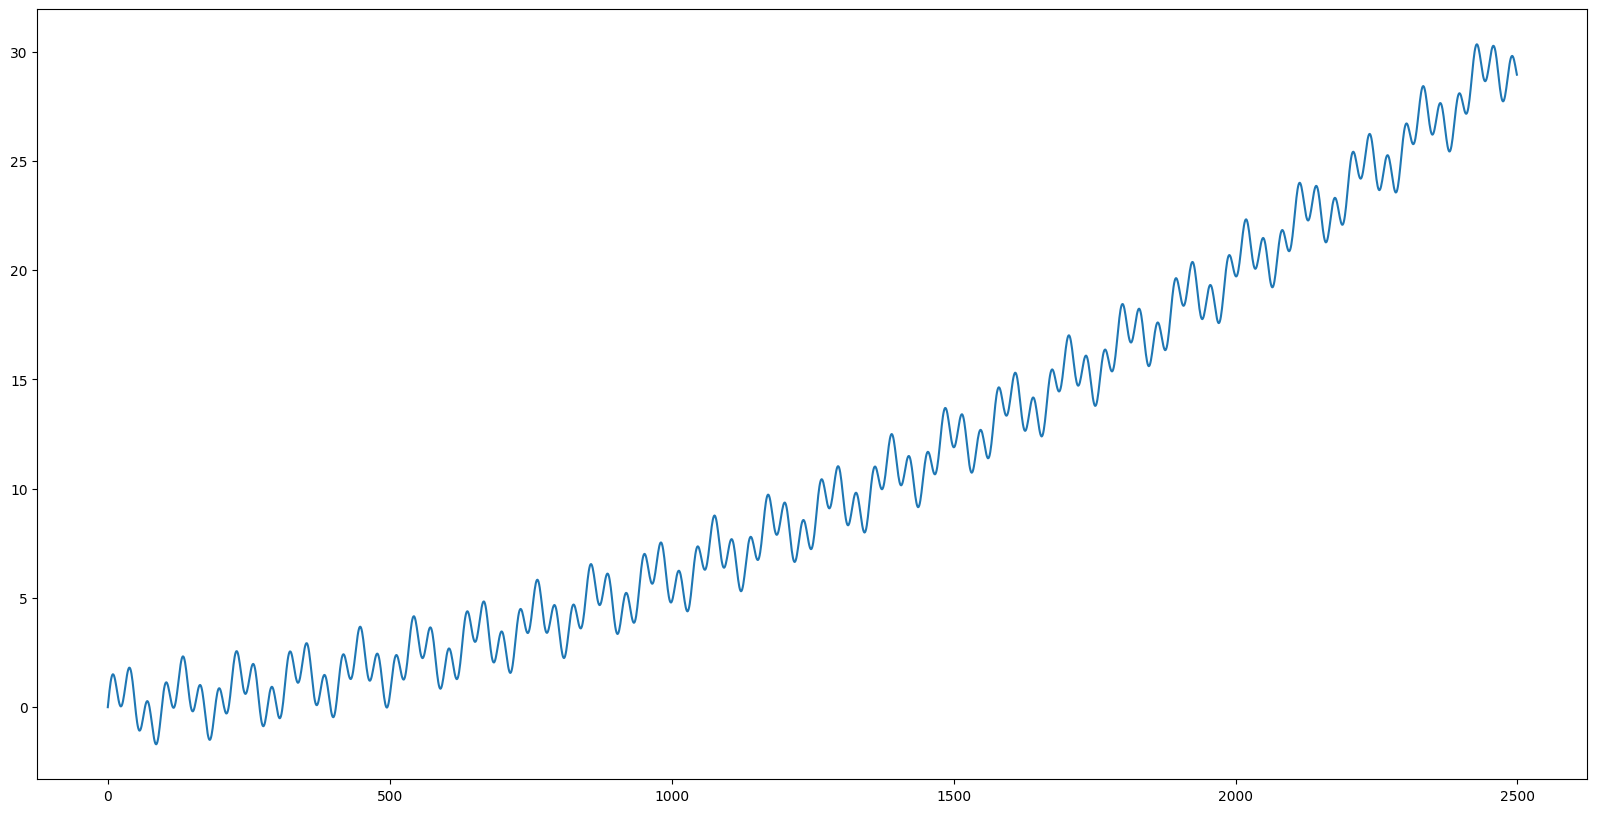

In [5]:
plt.figure(figsize=[20, 10])
plt.plot(synthetic_data)
plt.show()

In [6]:
min_value = synthetic_data.min()
max_value = synthetic_data.max()

In [7]:
data_seq = []
data_targets = []
sequence_len = 150
for i in range(len(synthetic_data) - sequence_len - 1):
    data_seq.append(torch.from_numpy(synthetic_data[i:i + sequence_len]))
    data_targets.append(synthetic_data[i + sequence_len + 1])

In [8]:
data = (torch.stack(data_seq).float() - min_value) / max_value
data_targets = (torch.Tensor(data_targets).float() - min_value) / max_value
train_indices = rng.random(len(data_seq)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_data, test_targets = data[test_indices], data_targets[test_indices]

In [9]:
class SimpleRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x
    
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model

SimpleRegressor(
  (linear1): Linear(in_features=150, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

In [11]:
model.train() 

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00668
Epoch: 10, loss: 0.000148
Epoch: 20, loss: 0.000117
Epoch: 30, loss: 0.000294
Epoch: 40, loss: 0.000141
Epoch: 50, loss: 6.51e-05
Epoch: 60, loss: 8.77e-05
Epoch: 70, loss: 0.000237
Epoch: 80, loss: 4.43e-05
Epoch: 90, loss: 5.24e-05
Epoch: 100, loss: 3.62e-05


In [12]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze()-test_targets.to(device)).mean())

tensor(0.0042, device='cuda:0')


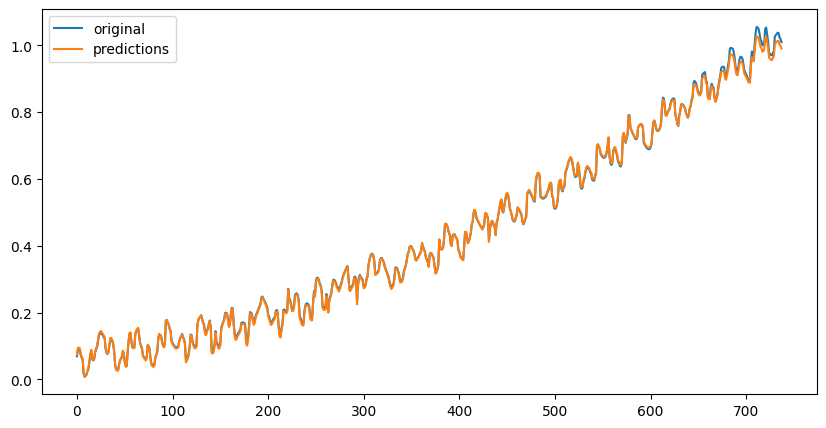

In [13]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Koniec laborki?

### Co poszło nie tak?

In [14]:
train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [15]:
model = SimpleRegressor(sequence_len, 5, 1).to(device)
model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)

        preds = model(x)
        preds = preds.squeeze(dim=1) 
        
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.000732
Epoch: 10, loss: 0.000213
Epoch: 20, loss: 6.69e-05
Epoch: 30, loss: 7.8e-05
Epoch: 40, loss: 8.06e-05
Epoch: 50, loss: 0.000146
Epoch: 60, loss: 0.000103
Epoch: 70, loss: 5.77e-05
Epoch: 80, loss: 2.49e-05
Epoch: 90, loss: 1.66e-05
Epoch: 100, loss: 5.43e-05


In [16]:
with torch.no_grad():
    test_preds = model(test_data.to(device))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.1153, device='cuda:0')


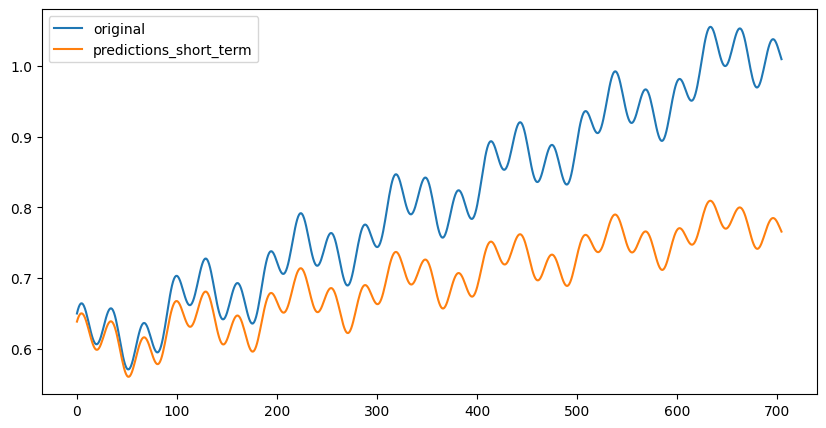

In [17]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets.numpy(), label='original')
plt.plot(test_preds.cpu().numpy(), label='predictions_short_term')
plt.legend()
plt.show()

# Sieć rekurencyjna

In [18]:
class RecurrentRegressor(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, num_state):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs + num_state, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear_out = nn.Linear(num_hidden, num_outputs)
        self.linear_state = nn.Linear(num_hidden, num_state)

    def forward(self, x, state):
        x = torch.cat([x, state], 1)
        x = self.linear1(x)
        x = self.act_fn(x)
        out = self.linear_out(x)
        state = self.linear_state(x)
        return out, state
    
model = RecurrentRegressor(1, 5, 1, 5).to(device)
model

RecurrentRegressor(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (act_fn): Tanh()
  (linear_out): Linear(in_features=5, out_features=1, bias=True)
  (linear_state): Linear(in_features=5, out_features=5, bias=True)
)

### Dokończ pętlę uczącą poniżej:

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device)
        targets = targets.to(device)
        loss_total = 0
        state = torch.zeros(len(x), 5).to(device)
        optimizer.zero_grad() 
        for i in range(x.size(1)):
            x_one = x[:,i].unsqueeze(1)
            if i < sequence_len - 1:
                target = x[:,i+1]
            else:
                target = targets
            preds, state = model(x_one, state)
            preds = preds.squeeze(dim=1) 
            loss = loss_fun(preds, target)
            loss_total += loss
        loss_total.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0182
Epoch: 10, loss: 0.000154
Epoch: 20, loss: 0.000185
Epoch: 30, loss: 0.000161
Epoch: 40, loss: 0.000139
Epoch: 50, loss: 0.000129
Epoch: 60, loss: 0.000118
Epoch: 70, loss: 0.000105
Epoch: 80, loss: 9.81e-05
Epoch: 90, loss: 9.44e-05
Epoch: 100, loss: 8.49e-05


In [20]:
with torch.no_grad():
    state = torch.zeros(len(test_data), 5).to(device)
    test_preds = []
    for i in range(test_data.size(1)):
        x_one = test_data[:, i].unsqueeze(1).to(device)
        preds, state = model(x_one, state)
    test_preds.append(preds)
    print(torch.abs((torch.cat(test_preds).squeeze() - test_targets.to(device))).mean())

tensor(0.0238, device='cuda:0')


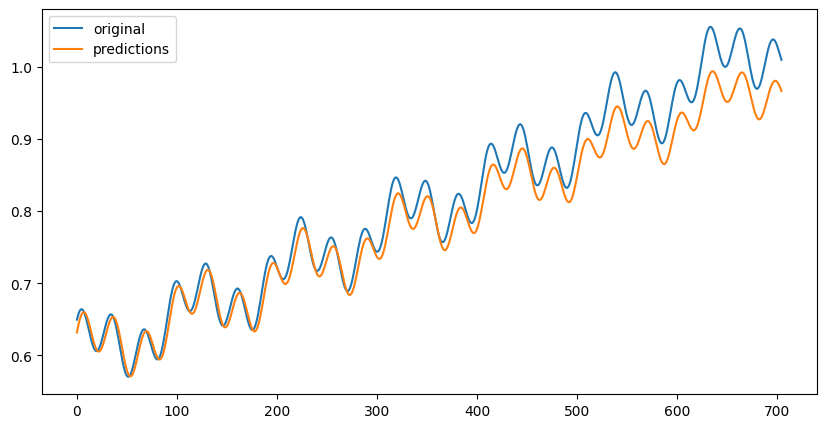

In [21]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(torch.cat(test_preds).squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

# Sieci rekurencyjne w Torchu

In [22]:
batch_size = 2
input_size = 3
hidden_size = 4
num_layers = 2
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=False) #batch_first=False is default!!
rnn

RNN(3, 4, num_layers=2)

In [23]:
with torch.no_grad():
    sequence_len = 5
    x = torch.randn(sequence_len, batch_size, input_size)
    h0 = torch.randn(num_layers, batch_size, hidden_size)
    output, hn = rnn(x, h0)
output

tensor([[[ 0.8784,  0.5012, -0.7968, -0.5309],
         [ 0.8957,  0.9332, -0.8151, -0.6866]],

        [[ 0.6840,  0.6705, -0.7472, -0.4019],
         [ 0.6958,  0.6196, -0.6968, -0.1428]],

        [[ 0.4440,  0.0918, -0.3899, -0.1846],
         [ 0.7236,  0.7528, -0.6545, -0.2558]],

        [[ 0.6846,  0.7215, -0.6448, -0.0707],
         [ 0.6750,  0.6301, -0.5132, -0.0933]],

        [[ 0.6774,  0.6724, -0.5134, -0.1677],
         [ 0.7789,  0.7794, -0.5602, -0.2235]]])

In [24]:
output[-1]

tensor([[ 0.6774,  0.6724, -0.5134, -0.1677],
        [ 0.7789,  0.7794, -0.5602, -0.2235]])

In [25]:
hn

tensor([[[-0.7372,  0.7240,  0.7730,  0.3657],
         [-0.7065,  0.8784,  0.8687,  0.7173]],

        [[ 0.6774,  0.6724, -0.5134, -0.1677],
         [ 0.7789,  0.7794, -0.5602, -0.2235]]])

In [26]:
class RNNRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.rnn(x, hidden)
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = RNNRegressor(1, 5, 2, 1).to(device)
model

RNNRegressor(
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden = model.init_hidden(x.size(0)).to(device)
        preds, last_hidden = model(x, hidden)
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00646
Epoch: 10, loss: 0.00237
Epoch: 20, loss: 0.000828
Epoch: 30, loss: 0.000424
Epoch: 40, loss: 0.000297
Epoch: 50, loss: 0.000253
Epoch: 60, loss: 0.000237
Epoch: 70, loss: 0.000197
Epoch: 80, loss: 0.000149
Epoch: 90, loss: 0.000117
Epoch: 100, loss: 9.66e-05


In [28]:
with torch.no_grad():
    hidden = model.init_hidden(len(test_data)).to(device)
    test_preds, _ = model(test_data.to(device).unsqueeze(2),hidden)
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean())

tensor(0.0625, device='cuda:0')


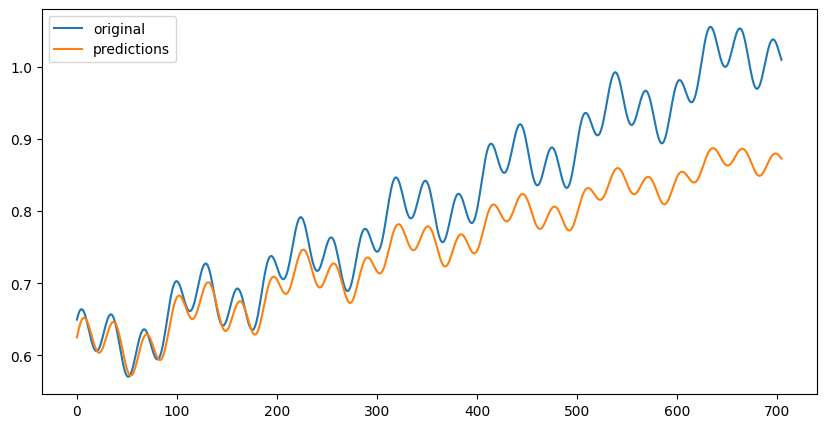

In [29]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

## Czy możemy jakoś rozdzielić krótką i długą pamięć?

![LSTM](https://cdn-images-1.medium.com/max/1000/1*Ht2-sUJHi65wDwnR276k3A.png)

In [30]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, hidden_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

In [31]:
print(output.size())
output

torch.Size([5, 3, 2])


tensor([[[-0.4043, -0.0016],
         [ 0.3495, -0.2683],
         [-0.0934, -0.0379]],

        [[-0.3668, -0.1956],
         [ 0.1113, -0.2413],
         [-0.2090, -0.1552]],

        [[-0.3192, -0.2821],
         [-0.0830, -0.2429],
         [-0.2061, -0.1980]],

        [[-0.2842, -0.2960],
         [-0.1785, -0.2692],
         [-0.2062, -0.2383]],

        [[-0.2823, -0.4123],
         [-0.1974, -0.3134],
         [-0.1953, -0.2766]]], grad_fn=<MkldnnRnnLayerBackward0>)

In [32]:
print(hn)
print(cn)

tensor([[[-0.2823, -0.4123],
         [-0.1974, -0.3134],
         [-0.1953, -0.2766]]], grad_fn=<StackBackward0>)
tensor([[[-0.3988, -0.6095],
         [-0.2826, -0.4623],
         [-0.2667, -0.3771]]], grad_fn=<StackBackward0>)


In [33]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        out = all_outputs[-1] # We are interested only in the last output
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1, 20, 2, 1).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 20, num_layers=2)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.00152
Epoch: 10, loss: 0.00148
Epoch: 20, loss: 0.000751
Epoch: 30, loss: 0.000541
Epoch: 40, loss: 0.000425
Epoch: 50, loss: 0.000344
Epoch: 60, loss: 0.000242
Epoch: 70, loss: 0.000106
Epoch: 80, loss: 1.37e-05
Epoch: 90, loss: 2.02e-05
Epoch: 100, loss: 1.05e-05


In [35]:
with torch.no_grad():
    hidden, state = model.init_hidden(test_data.size(0))
    hidden, state = hidden.to(device), state.to(device) 
    test_preds, _ = model(test_data.to(device).unsqueeze(2), (hidden, state))
    print(torch.abs(test_preds.squeeze() - test_targets.to(device)).mean().item())

0.01948215626180172


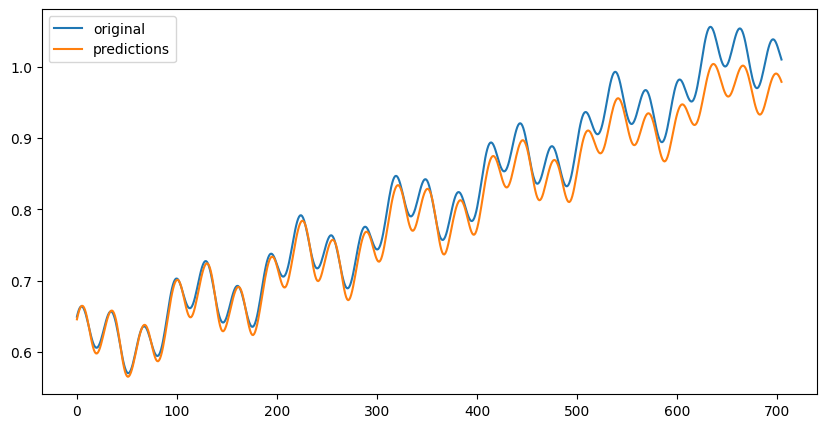

In [36]:
plt.figure(figsize=[10, 5])
plt.plot(test_targets, label='original')
plt.plot(test_preds.squeeze().cpu().numpy(), label='predictions')
plt.legend()
plt.show()

### Mini zadanie: Jak wyglądałyby predykcje w oparciu o poprzednie predykcje?

In [37]:
with torch.no_grad():
    hidden, state = model.init_hidden(1)
    hidden, state = hidden.to(device), state.to(device) 
    hidden = (hidden,state)
    x_one = test_targets[0:1].unsqueeze(0).to(device)
    preds = []
    for i in range(len(test_targets)):
        x_one, hidden = model(x_one.unsqueeze(0), hidden)
        preds.append(x_one.item())

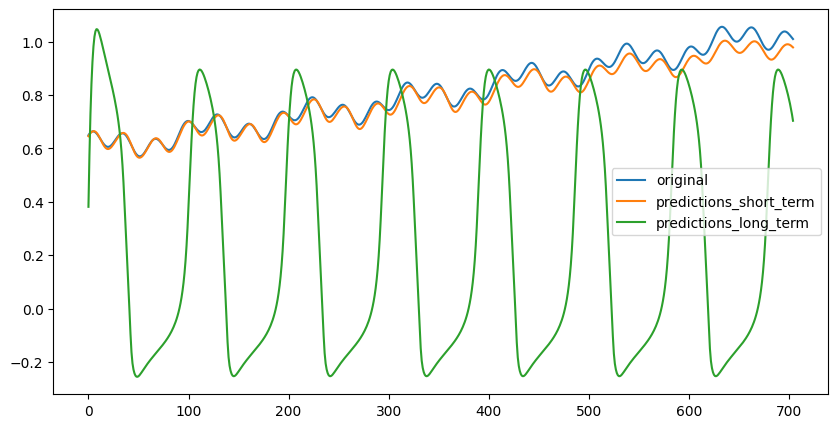

In [38]:
plt.figure(figsize=[10,5])
plt.plot(test_targets, label = 'original')
plt.plot(test_preds.squeeze().cpu().numpy(), label = 'predictions_short_term')
plt.plot(preds, label = 'predictions_long_term')
plt.legend()
plt.show()

# Predykcja Sequence to sequence

In [39]:
stock_price = pd.read_csv("all_stocks_5yr.csv")

In [40]:
mastercard_stock = stock_price[stock_price.Name=="MA"].open.values
visa_stock = stock_price[stock_price.Name=="V"].open.values

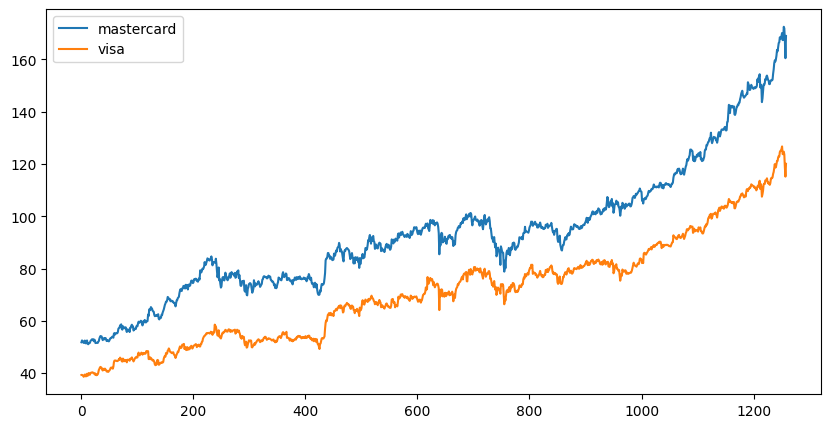

In [41]:
plt.figure(figsize=[10, 5])
plt.plot(mastercard_stock, label='mastercard')
plt.plot(visa_stock, label='visa')
plt.legend()
plt.show()

In [42]:
m_min_value = mastercard_stock.min()
m_max_value = mastercard_stock.max()
v_min_value = visa_stock.min()
v_max_value = visa_stock.max()

In [43]:
data_seq = []
data_targets = []
sequence_len = 50
for i in range(len(mastercard_stock) - sequence_len):
    data_seq.append(torch.from_numpy(mastercard_stock[i:i + sequence_len]))
    data_targets.append(torch.from_numpy(visa_stock[i:i + sequence_len]))
    
data = (torch.stack(data_seq).float() - m_min_value) / m_max_value
data_targets = (torch.stack(data_targets).float() - v_min_value) / v_max_value    

train_split = int(len(data) * 0.7)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
train_set = torch.utils.data.TensorDataset(data[:train_split], data_targets[:train_split])
train_loader = DataLoader(train_set, batch_size=32, drop_last=True)
test_data, test_targets = data[train_split:], data_targets[train_split:]

In [44]:
sequence_length = 5
num_layers = 1
batch_size = 3
hidden_size = 2
projection_size = 1

lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, proj_size=projection_size)
lstm_input = torch.randn(sequence_length, batch_size, 1)
hidden_0 = torch.randn(num_layers, batch_size, projection_size)
cell_state_0 = torch.randn(num_layers, batch_size, hidden_size)
output, (hn, cn) = lstm(lstm_input, (hidden_0, cell_state_0))

/home/natalia/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:878: UserWarning: LSTM with projections is not supported with oneDNN. Using default implementation. (Triggered internally at ../aten/src/ATen/native/RNN.cpp:1479.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [45]:
output

tensor([[[ 0.0140],
         [-0.1299],
         [-0.3248]],

        [[-0.1029],
         [-0.1869],
         [-0.1679]],

        [[-0.0338],
         [-0.0708],
         [-0.1532]],

        [[-0.0607],
         [-0.1142],
         [-0.2078]],

        [[-0.0592],
         [-0.1814],
         [-0.2289]]], grad_fn=<StackBackward0>)

In [46]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size=out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 50, 2, 1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 50, proj_size=1, num_layers=2)
)

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, last_hidden = model(x, (hidden,state))
        preds = preds.squeeze(2)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0293
Epoch: 10, loss: 0.0176
Epoch: 20, loss: 0.00601
Epoch: 30, loss: 0.00435
Epoch: 40, loss: 0.00377
Epoch: 50, loss: 0.00352
Epoch: 60, loss: 0.00337
Epoch: 70, loss: 0.00327
Epoch: 80, loss: 0.00318
Epoch: 90, loss: 0.00311
Epoch: 100, loss: 0.00304


In [48]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    for i in range(0, len(test_targets), sequence_len):
        hidden, state = model.init_hidden(1)
        hidden, state = hidden.to(device), state.to(device) 
        selected_test_targets.append(test_targets[i])
        pred, _ = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden, state))
        preds.append(pred.squeeze())

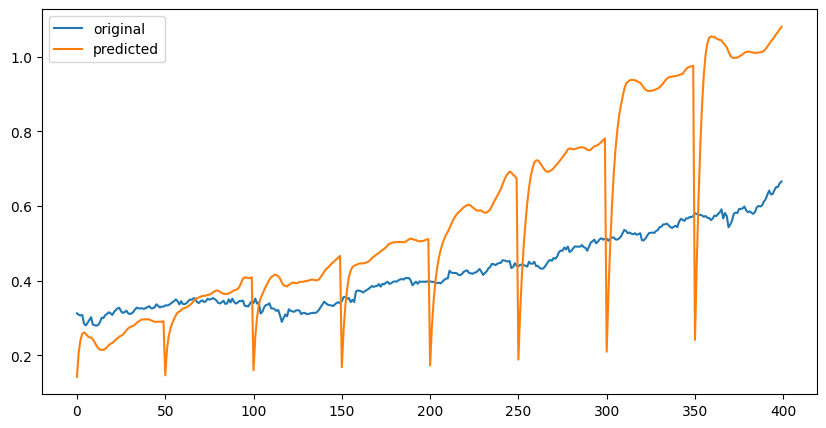

In [49]:
plt.figure(figsize=[10, 5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label='original')
plt.plot(torch.cat(preds).cpu().numpy(), label='predicted')
plt.legend()
plt.show()

### Co się stało, skąd takie dziwne predykcje?

In [50]:
with torch.no_grad():
    selected_test_targets = []
    preds = []
    hidden, state = model.init_hidden(1)
    hidden, state = hidden.to(device), state.to(device) 
    for i in range(0,len(test_targets),sequence_len):
        selected_test_targets.append(test_targets[i])
        pred, hidden_out = model(test_data[i].to(device).unsqueeze(0).unsqueeze(2), (hidden,state))
        hidden, state = hidden_out
        preds.append(pred.squeeze())

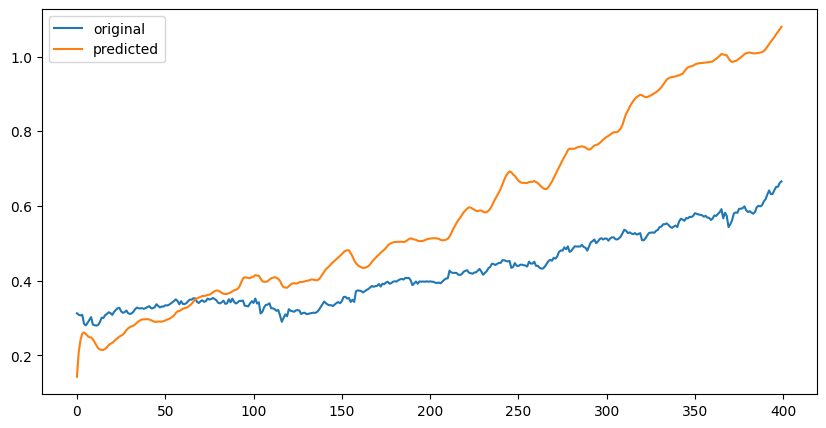

In [51]:
plt.figure(figsize=[10,5])
plt.plot(torch.cat(selected_test_targets).cpu().numpy(), label = 'original')
plt.plot(torch.cat(preds).cpu().numpy(), label = 'predicted')
plt.legend()
plt.show()

# Klasyfikacja serii

In [52]:
libras = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data", header=None)

In [53]:
libras.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.79691,0.38194,0.79691,0.37731,0.79884,0.37731,0.79497,0.37731,0.77563,0.35417,...,0.51389,0.39845,0.42593,0.47389,0.36111,0.55899,0.31250,0.63830,0.29398,1
1,0.67892,0.27315,0.68085,0.27315,0.68085,0.27315,0.68085,0.27315,0.67892,0.26852,...,0.57407,0.17795,0.63657,0.17215,0.67361,0.17021,0.69213,0.17215,0.69213,1
2,0.72147,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,0.72340,0.23611,...,0.30556,0.59768,0.25926,0.67118,0.25231,0.73501,0.26620,0.78143,0.27778,1
3,0.56480,0.32407,0.56286,0.32407,0.56093,0.32407,0.55899,0.32407,0.55899,0.32407,...,0.49074,0.26306,0.42361,0.33269,0.34722,0.41006,0.28009,0.49130,0.24306,1
4,0.67118,0.38426,0.67118,0.38657,0.67311,0.38657,0.67311,0.38426,0.67311,0.37963,...,0.76389,0.44101,0.64120,0.45068,0.54167,0.47776,0.44213,0.53191,0.34259,1


In [54]:
classes = libras[90].values
data = libras.values[:, :-1]

In [55]:
data = torch.from_numpy(data).float()
data_targets = torch.from_numpy(classes).long()

train_indices = rng.random(len(data)) > 0.3
test_indices = ~train_indices
train_set = torch.utils.data.TensorDataset(data[train_indices], data_targets[train_indices])
train_loader = DataLoader(train_set, batch_size=32)
test_data, test_targets = data[test_indices], data_targets[test_indices]

### Napisz klasyfikator

In [56]:
class LSTMRegressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, bidirectional=bidirectional, dropout=0.4)
        self.fc = nn.Linear(hidden_size*90*self.bidirectional, out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional , batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        x = torch.transpose(x,0,1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs,0,1)
        out = torch.flatten(all_outputs,1)
        x = self.fc(out)
        return x, hidden
    
model = LSTMRegressor(1,5,2,16).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 5, num_layers=2, dropout=0.4)
  (fc): Linear(in_features=450, out_features=16, bias=True)
)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fun = nn.CrossEntropyLoss()

# Training loop
for epoch in range(101):
    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)
#         x = x.unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        preds, _ = model(x, (hidden,state))
        preds = preds.squeeze(1)
        optimizer.zero_grad() 
        loss = loss_fun(preds, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 2.83
Epoch: 10, loss: 2.16
Epoch: 20, loss: 1.93
Epoch: 30, loss: 1.46
Epoch: 40, loss: 0.53
Epoch: 50, loss: 0.574
Epoch: 60, loss: 0.441
Epoch: 70, loss: 0.54
Epoch: 80, loss: 0.373
Epoch: 90, loss: 0.372
Epoch: 100, loss: 0.387


In [58]:
with torch.no_grad():
    hidden, state = model.init_hidden(len(test_data))
    hidden, state = hidden.to(device), state.to(device) 
    preds,_ =  model(test_data.to(device).unsqueeze(2), (hidden,state))
print(f"Accuracy: {(torch.argmax(preds,1).cpu()==test_targets).sum().item()/len(test_targets):.3}")

Accuracy: 0.24


# Dane o różnej długości

In [59]:
from torch.utils.data import Dataset

class VariableLenDataset(Dataset):
    def __init__(self, in_data, target):
        self.data = [(x, y) for x, y in zip(in_data, target)]      

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        in_data, target = self.data[idx]
        return in_data, target

In [60]:
min_gen_val = 10
max_gen_val = 1001
samples = 1000
max_gen_len = 32

data = []
targets = []
max_val = -1
for _ in range(samples):
    seq_len = rng.integers(low=1, high=max_gen_len, size=1)
    data_in = rng.integers(low=min_gen_val, high=max_gen_val, size=seq_len)
    data_sum = np.array([data_in[:i + 1].sum() for i in range(len(data_in))])
    data.append(torch.from_numpy(data_in))
    targets.append(torch.from_numpy(data_sum))
    max_val = data_sum[-1] if data_sum[-1] > max_val else max_val

In [61]:
train_indices = int(len(data) * 0.7)
data = [(x / max_val).float() for x in data]
targets = [(x / max_val).float() for x in targets]
train_set = VariableLenDataset(data[:train_indices], targets[:train_indices])
test_set = VariableLenDataset(data[train_indices:], targets[train_indices:])

In [62]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

pad = 0

def pad_collate(batch, pad_value=0):
    xx, yy = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=pad_value)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=pad_value)

    return xx_pad, yy_pad, x_lens, y_lens

In [63]:
train_loader = DataLoader(train_set, batch_size=50, shuffle=True, collate_fn=pad_collate)
test_loader = DataLoader(test_set, batch_size=50, shuffle=False, drop_last=False, collate_fn=pad_collate)

In [64]:
print(len(train_set[0][0]))
print(len(train_set[1][0]))

28
13


In [65]:
next(iter(train_loader))

(tensor([[0.0371, 0.0230, 0.0041,  ..., 0.0000, 0.0000, 0.0000],
         [0.0418, 0.0445, 0.0297,  ..., 0.0000, 0.0000, 0.0000],
         [0.0477, 0.0207, 0.0472,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0008, 0.0369, 0.0016,  ..., 0.0301, 0.0197, 0.0000],
         [0.0362, 0.0078, 0.0255,  ..., 0.0000, 0.0000, 0.0000],
         [0.0292, 0.0329, 0.0419,  ..., 0.0000, 0.0000, 0.0000]]),
 tensor([[3.7131e-02, 6.0133e-02, 6.4276e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.1806e-02, 8.6321e-02, 1.1607e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [4.7703e-02, 6.8420e-02, 1.1564e-01,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         ...,
         [8.4993e-04, 3.7769e-02, 3.9416e-02,  ..., 8.4436e-01, 8.6406e-01,
          0.0000e+00],
         [3.6175e-02, 4.3984e-02, 6.9482e-02,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [2.9216e-02, 6.2151e-02, 1.0401e-01,  ..., 0.0000e+00, 0.0000e+00,
         

In [66]:
class LSTM_Seq_Regressor(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.proj_size = out_size
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, proj_size = out_size)
        
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.proj_size)
        state = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden, state
    
    def forward(self, x, hidden):
        # x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        # all_outputs = torch.transpose(all_outputs, 0, 1)
        return all_outputs, hidden
    
model = LSTM_Seq_Regressor(1, 200, 1, 1).to(device)
model

LSTM_Seq_Regressor(
  (lstm): LSTM(1, 200, proj_size=1)
)

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.MSELoss()

# Training loop
for epoch in range(101):
    for x, targets, x_len, target_len in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device) 
        
        x = torch.transpose(x, 0, 1)
        preds, _ = model(x, (hidden, state))
        preds = torch.transpose(preds, 0, 1)
        
#         x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
#         preds_packed, _ = model(x_packed, (hidden, state))
#         preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        optimizer.zero_grad()
        mask = targets != pad
        loss = loss_fun(preds[mask], targets[mask])
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.0633
Epoch: 10, loss: 0.00402
Epoch: 20, loss: 0.00155
Epoch: 30, loss: 0.00123
Epoch: 40, loss: 0.00076
Epoch: 50, loss: 0.000654
Epoch: 60, loss: 0.000547
Epoch: 70, loss: 0.000295
Epoch: 80, loss: 0.000127
Epoch: 90, loss: 5.19e-05
Epoch: 100, loss: 2.87e-05


In [68]:
with torch.no_grad():
    for x, targets, x_len, target_len in test_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.shape[0])
        hidden, state = hidden.to(device), state.to(device)

#         x = torch.transpose(x, 0, 1)        
#         preds, _ = model(x, (hidden, state))
#         preds = torch.transpose(preds, 0, 1)
        
        x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        preds_packed, _ = model(x_packed, (hidden, state))
        preds, pred_len = pad_packed_sequence(preds_packed, batch_first=True, padding_value=pad)
        
        preds = preds.squeeze(2)
        mask_tgt = targets != pad
        print(targets)
        print(preds)
        print(torch.abs(preds[mask_tgt] - targets[mask_tgt]).mean())
        print()

tensor([[0.0390, 0.0568, 0.0889,  ..., 0.0000, 0.0000, 0.0000],
        [0.0122, 0.0377, 0.0884,  ..., 0.0000, 0.0000, 0.0000],
        [0.0493, 0.0578, 0.0943,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0308, 0.0579, 0.0932,  ..., 0.0000, 0.0000, 0.0000],
        [0.0149, 0.0165, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
        [0.0504, 0.0844, 0.0893,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
tensor([[0.0359, 0.0537, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
        [0.0114, 0.0371, 0.0871,  ..., 0.0000, 0.0000, 0.0000],
        [0.0453, 0.0542, 0.0907,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0283, 0.0550, 0.0902,  ..., 0.0000, 0.0000, 0.0000],
        [0.0138, 0.0173, 0.0524,  ..., 0.0000, 0.0000, 0.0000],
        [0.0463, 0.0789, 0.0849,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
tensor(0.0046, device='cuda:0')

tensor([[0.0053, 0.0350, 0.0863,  ..., 0.0000, 0.0000, 0.0000],
        [0.0183, 0.0517, 0.0810,  ..., 0.0000, 0.0000, 0.00